# Background Story

I have a thought of teaching Python in Cantonese and listing the course on Udemy. Therefore I created this web scraping script to collect all the meta information of the courses with the keyword "Python" on Udemy to understand the general information of the Python-related courses such as the average course length, the namimg of the course, and others. I would also want to learn what attributes of the courses would contributed to the course rating.

### Few notes before running the program

- The chrome web driver must support the current version of the brower you are using on your local computer in order for the script to work
- The class names are often changed so the script might not work as the elements cannot be located correctly. I have checked the class names on 10/7/2020 and therefore I am sure that this script works at that time.

In [71]:
from selenium import webdriver
import matplotlib.pyplot as plt
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import pandas as pd
import time
from datetime import datetime

In [72]:
class ScrapeClassInfo:
    
    def __init__(self, page_nums, term):
        self.page_nums = page_nums
        self.term = term
    
    def set_up_driver(self):
        driver_path = './webdrivers/chromedriver'
        self.driver = webdriver.Chrome(driver_path)
    
    def open_search_result(self):
        self.base_url = 'https://www.udemy.com/'
        self.driver.maximize_window()
        self.driver.implicitly_wait(3)
        self.driver.get(self.base_url)
        time.sleep(2)
        
        _search_bar = "//input[@name='q']"
        _search_button = "//button[@type='submit']"
        
        search_bar_ele = self.driver.find_element(By.XPATH, _search_bar)
        search_bar_ele.send_keys(self.term)
        
        search_btn_ele = self.driver.find_element(By.XPATH, _search_button)
        search_btn_ele.click()
        
        time.sleep(2)
        
    def flip_page(self, page):
        print("Fliping page to " + str(page))         
        _next_button = "//a[starts-with(@href, '/courses/search/?p=" + str(page) + "&q=" + self.term + "&src=ukw')]"
        next_btn = self.driver.find_element(By.XPATH, _next_button)
        next_btn.click()
        time.sleep(3)
        
    def start_scraping(self):
        data_list = []
        for one_page in range(1, self.page_nums):
            print("Start scraping page " + str(one_page))
            soup = BeautifulSoup(self.driver.page_source)
            all_classes = soup.select("div[class^='course-card--container--']")
            for one_class in all_classes:
                one_class_data_row = []
                # Get the values
                title = one_class.select("div[class^='udlite-focus-visible-target udlite-heading-md course-card--course-title--']")[0].text
                num_lectures = one_class.select("span[class^='course-card--row--']")[1].text
                lecture_duration = one_class.select("span[class^='course-card--row--']")[0].text
                level = one_class.select("span[class^='course-card--row--']")[2].text
                prices = one_class.select("div[class^='price-text--price-part--']")
                if len(prices) == 1:
                    price = prices[0].select("span:nth-child(2)")[0].text
                    sale_price = 0
                elif len(prices) == 2:
                    price = prices[1].div.select("span:nth-child(2)")[0].text
                    sale_price = prices[0].select("span:nth-child(2)")[0].text
                else:
                    print("Price Error!")
                    print(one_class)
                rating = one_class.select("span[class^='udlite-heading-sm star-rating--rating-number--']")[0].text
                num_rating = one_class.select("span[class^='udlite-text-xs course-card--reviews-text--']")[0].text
                
                one_class_data_row.extend([title, num_lectures, lecture_duration, level, price, sale_price, rating, num_rating])
                # Add one course to the data list
                data_list.append(one_class_data_row)
                
            # Flip page
            one_page += 1
            self.flip_page(one_page)
                
        return data_list
    
    def dataframe_creation(self, values):
        columns = ['name','lecture_length','duration','level','price','sale_price','rating','num_rating']
        values = values
        return pd.DataFrame(values, columns=columns)
        
        
    def clean_dataframe(self, df):
        df['lecture_length'] = df.lecture_length.str.split(' ').str.get(0).astype(int)
        df['duration'] = df.duration.str.split(' ').str.get(0).astype(float)
        df.price = df.price.str.strip('$').astype(float)
        df.sale_price = df.sale_price.str.strip('$').astype(float)
        df.num_rating = df.num_rating.str.split(' ').str.get(0).str.lstrip('(').str.rstrip(')').str.split(',').str.join('').astype(int)
        # Saving the dataframe         
        formatted_datetime = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')
        self.file_name = formatted_datetime + '_' + self.term + '_' + 'udemy.csv'
        df.to_csv(self.file_name, index=False)
    
    def quit(self):
        self.driver.quit()
        
    def main(self):
        self.set_up_driver()
        self.open_search_result()
        self.clean_dataframe(self.dataframe_creation(self.start_scraping()))
        self.quit()

In [73]:
scrape_class_info = ScrapeClassInfo(10, 'python')
scrape_class_info.main()

Start scraping page 1
Fliping page to 2
Start scraping page 2
Fliping page to 3
Start scraping page 3
Fliping page to 4
Start scraping page 4
Fliping page to 5
Start scraping page 5
Fliping page to 6
Start scraping page 6
Fliping page to 7
Start scraping page 7
Fliping page to 8
Start scraping page 8
Fliping page to 9
Start scraping page 9
Fliping page to 10


In [74]:
df = pd.read_csv(scrape_class_info.file_name)

In [75]:
df.head(5)

,name,lecture_length,duration,level,price,sale_price,rating,num_rating
0,Learn Python Programming Masterclass,411,58.5,All Levels,109.99,14.99,4.5,59322
1,The Python Mega Course: Build 10 Real World Ap...,277,25.5,All Levels,109.99,15.99,4.5,42978
2,Python for Beginners: Learn Python Programming...,78,3.0,All Levels,99.99,13.99,4.4,10699
3,The Python Bible™ | Everything You Need to Pro...,74,9.0,Beginner,94.99,12.99,4.6,29646
4,Python for Absolute Beginners,89,3.0,Beginner,49.99,13.99,4.4,17533


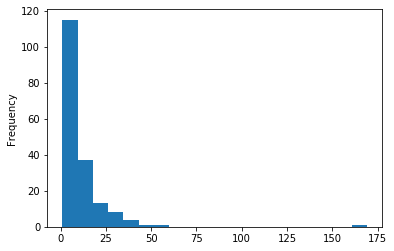

In [227]:
df.duration.plot.hist(bins=20)
plt.show()

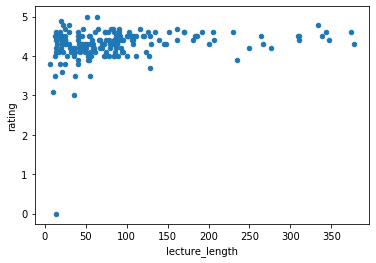

In [220]:
df.plot.scatter(x='lecture_length', y='rating')

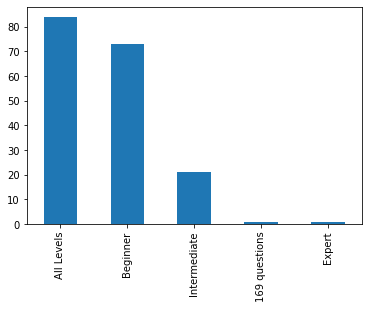

In [223]:
df['level'].value_counts().plot.bar()

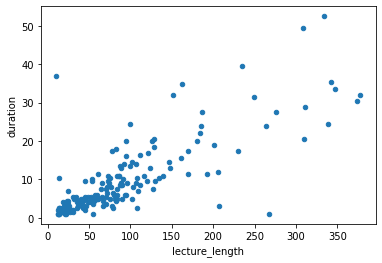

In [216]:
df.drop(index=df[df.duration == df.duration.max()].index).plot.scatter(x='lecture_length', y='duration')